In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
from predictables.util import to_pl_lf
from predictables.util.report import Report
from predictables.univariate import Univariate
import numpy as np


# load data
df = load_breast_cancer(as_frame=True).frame
df.columns = [c.replace(" ", "_") for c in df.columns]
df["cv"] = np.random.randint(1, 6, df.shape[0])
df = to_pl_lf(df)

df.head().collect()

mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,radius_error,texture_error,perimeter_error,area_error,smoothness_error,compactness_error,concavity_error,concave_points_error,symmetry_error,fractal_dimension_error,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target,cv
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,i32
17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,0,4
20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.186,0.275,0.08902,0,1
19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02058,0.0225,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.243,0.3613,0.08758,0,3
11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0.4956,1.156,3.445,27.23,0.00911,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173,0,5
20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.01149,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.2,1575.0,0.1374,0.205,0.4,0.1625,0.2364,0.07678,0,1


In [2]:
df.collect().shape

(569, 32)

### fit each fold to a model

In [3]:
X, y = (
    df.collect().to_pandas().drop(columns="target"),
    df.select("target").collect().to_pandas()["target"],
)
X.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,cv
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,4
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,3
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,5
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [4]:
df = df.collect().to_pandas()
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target,cv
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0,4
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,3
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0,5
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0,1


TypeError: 'Axes' object is not callable

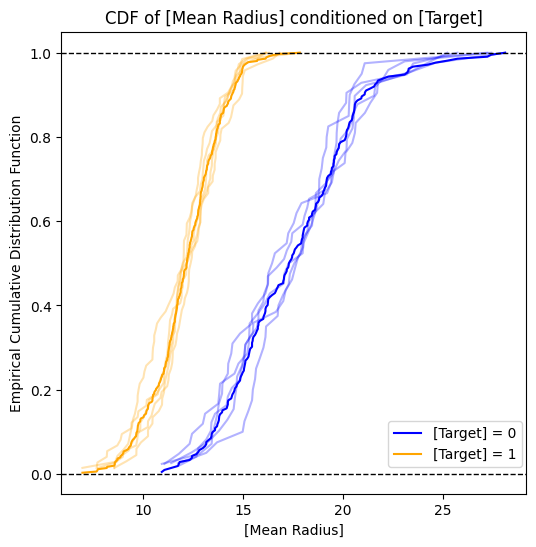

In [8]:
filename = f'./test_{np.random.randint(0, 123456789)}.pdf'
margins = [0.25, 0.25, 0.5, 0.5]

ua = Univariate(df, 'cv', 'mean_radius', 'target', time_series_validation=False)

func = lambda: ua.plot_cdf(figsize=(6,6))

Report(filename, margins).plot_no_caption(func(), 6, 6)

In [ ]:
filename = f'./test_{np.random.randint(0, 123456789)}.pdf'
margins = [0.25, 0.25, 0.5, 0.5]

rpt = (
    Univariate
        ._rpt_title_page(filename=filename, margins=margins)
        .title('Univariate Analysis - Hit Ratio Model')
        .author('Andy Weaver')
        .date()
)

for col in df.columns[:1]:
    if col not in ["target", "cv"]:
        df1 = pd.concat([df[col], y, df['cv']], axis=1)
        df1.columns = [col, 'target', 'cv']

        ua = Univariate(df1, 'cv', col, 'target', time_series_validation=False)
        rpt = ua.add_to_report(rpt)
    

rpt.build()

AttributeError: 'NoneType' object has no attribute 'now'